In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada VGG16 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import statistics
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

conv_base  = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [3]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/Database3.zip #comando linux

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database3/Train/nv/ISIC_0026937.jpg  
  inflating: Database3/Train/nv/ISIC_0026939.jpg  
  inflating: Database3/Train/nv/ISIC_0026942.jpg  
  inflating: Database3/Train/nv/ISIC_0026943.jpg  
  inflating: Database3/Train/nv/ISIC_0026945.jpg  
  inflating: Database3/Train/nv/ISIC_0026946.jpg  
  inflating: Database3/Train/nv/ISIC_0026949.jpg  
  inflating: Database3/Train/nv/ISIC_0026971.jpg  
  inflating: Database3/Train/nv/ISIC_0026973.jpg  
  inflating: Database3/Train/nv/ISIC_0026974.jpg  
  inflating: Database3/Train/nv/ISIC_0026977.jpg  
  inflating: Database3/Train/nv/ISIC_0026979.jpg  
  inflating: Database3/Train/nv/ISIC_0026980.jpg  
  inflating: Database3/Train/nv/ISIC_0026982.jpg  
  inflating: Database3/Train/nv/ISIC_0026983.jpg  
  inflating: Database3/Train/nv/ISIC_0026985.jpg  
  inflating: Database3/Train/nv/ISIC_0026994.jpg  
  inflating: Database3/Train/nv/ISIC_0026997.jpg  
  inflating: Database

In [4]:
#@title Ajustando los datos de la BD
train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#validation_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(validation_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#test_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(test_dataset_n))


Found 5284 files belonging to 4 classes.
Found 2263 files belonging to 4 classes.
Found 1884 files belonging to 4 classes.


In [5]:
#@title La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [6]:
#@title ##Transformaciones para expandir las imágenes y definición de la arquitectura##
checkpoint_filepath = 'bestresultsmodel.h5' #'/content'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=0,
        save_best_only=True)
]

In [7]:
pip install iterative-stratification

In [30]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
train_images = np.concatenate(list(train_dataset.map(lambda x, y:x)))
train_labels = np.concatenate(list(train_dataset.map(lambda x, y:y)))

val_images = np.concatenate(list(validation_dataset.map(lambda x, y:x)))
val_labels = np.concatenate(list(validation_dataset.map(lambda x, y:y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)

kfold = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=1)

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Test_scores1 = []
Test_scores2 = []
predicciones = []
history1 = []
labels_fit = []
cont = 0

In [31]:
def generate_model():
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = keras.applications.inception_v3.preprocess_input(x)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(385, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  return model

In [12]:
   model = generate_model()
   model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       7         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 180, 180, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 180, 180, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                           

In [32]:
for train, val in kfold.split(inputs, targets):
   model = generate_model()

   x_train, x_val = inputs[train], inputs[val]
   y_train, y_val = targets[train], targets[val]

   model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

   history = model.fit(
       x_train, y_train,
       epochs=1000,
       batch_size=64,
       validation_data=(x_val, y_val),
       callbacks=callbacks_list)

   print("--------------------------Test Results------------------------")

   pre = model.predict(test_dataset)
   predicciones.append(np.argmax(pre, axis = - 1))

   test_scores = model.evaluate(test_dataset, verbose=2)
   print("Test Loss:", test_scores[0])
   print("Test Accuracy:", test_scores[1])
   Test_scores1.append(test_scores[0])
   Test_scores2.append(test_scores[1])
   cont += 1

# model = generate_model()                              #Usar KFold no parece que sea la mejor opción, usar el método de entrenar normal da mejores resultados

# model.compile(loss="categorical_crossentropy",
#               optimizer=keras.optimizers.Adam(learning_rate=1e-2),
#               metrics=["accuracy"])

# history = model.fit(
#     train_dataset,
#     epochs=50,
#     batch_size=32,
#     validation_data=(validation_dataset),
#     callbacks=callbacks_list)

print(Test_scores1)
mean1 = statistics.mean(Test_scores1)
print(mean1)

print(Test_scores2)
mean2 = statistics.mean(Test_scores2)
print(mean2)

Epoch 1/1000
104/104 [==============================] - 13s 68ms/step - loss: 23.6862 - accuracy: 0.4087 - val_loss: 10.6138 - val_accuracy: 0.4401 - lr: 0.0010
Epoch 2/1000
104/104 [==============================] - 5s 47ms/step - loss: 8.7941 - accuracy: 0.5462 - val_loss: 7.8279 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 3/1000
104/104 [==============================] - 5s 46ms/step - loss: 6.8531 - accuracy: 0.6049 - val_loss: 6.3848 - val_accuracy: 0.7073 - lr: 0.0010
Epoch 4/1000
104/104 [==============================] - 5s 46ms/step - loss: 5.7006 - accuracy: 0.6479 - val_loss: 5.3389 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 5/1000
104/104 [==============================] - 5s 47ms/step - loss: 4.9182 - accuracy: 0.6723 - val_loss: 4.5342 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 6/1000
104/104 [==============================] - 5s 47ms/step - loss: 4.4561 - accuracy: 0.6853 - val_loss: 4.3622 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 7/1000
104/104 [===========================

In [33]:
print("-------------------------------------------------------------------------------------Test Results-------------------------------------------------------------------------------------")
print("Test Loss results:", Test_scores1)
print("Test Loss mean:", mean1)
print("Test Accuracy results:", Test_scores2)
print("Test Accuracy mean:", mean2)

-------------------------------------------------------------------------------------Test Results-------------------------------------------------------------------------------------
Test Loss results: [3.860586643218994, 3.965317487716675, 3.747124433517456, 3.8926150798797607, 4.001108169555664, 3.7903099060058594, 3.7351882457733154, 4.035796642303467]
Test Loss mean: 3.878505825996399
Test Accuracy results: [0.662420392036438, 0.675159215927124, 0.6640127301216125, 0.650212287902832, 0.6003184914588928, 0.7112526297569275, 0.7070063948631287, 0.537685751914978]
Test Accuracy mean: 0.6510084867477417


In [34]:
print("--------------------------Test Results------------------------")
x1 = np.std(Test_scores1)
x2 = np.std(Test_scores2)
print("Standard deviation of accuracy", x2)
print("Standard deviation of loss", x1)

--------------------------Test Results------------------------
Standard deviation of accuracy 0.05368877200252452
Standard deviation of loss 0.10805536063844907


<ipython-input-201-303843e14a0a>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, "bo", label="Test accuracy", color="green")
<ipython-input-201-303843e14a0a>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label="Test loss", color="green")


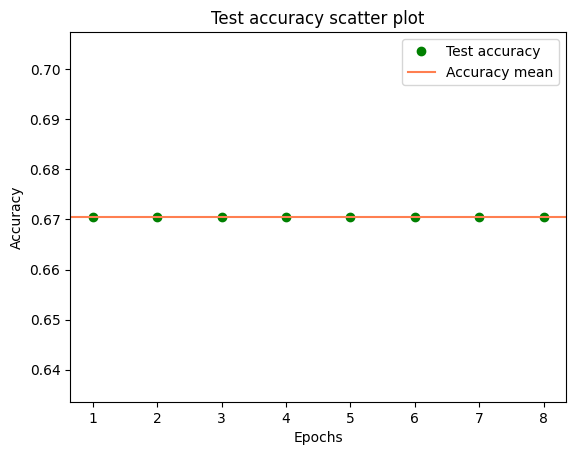

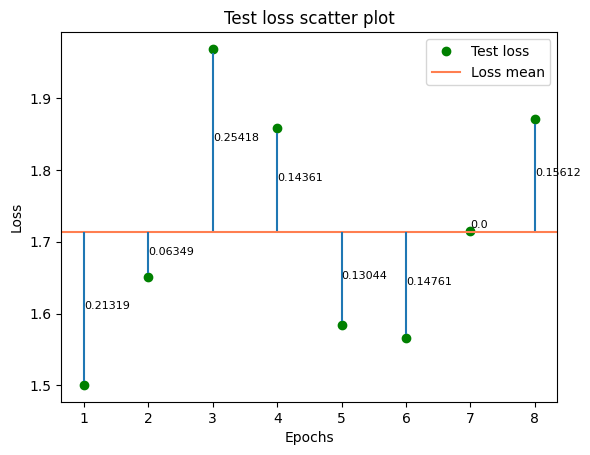

In [ ]:
acc = [0.6704999804496765, 0.6704999804496765, 0.6704999804496765, 0.6704999804496765, 0.6704999804496765, 0.6704999804496765, 0.6704999804496765, 0.6704999804496765]
meanacc = 0.6704999804496765
loss = [1.5007688999176025, 1.6504671573638916, 1.9681396484375, 1.8575630187988281, 1.583511471748352, 1.5663429498672485, 1.714737057685852, 1.8700731992721558]
meanloss = 1.7139504253864288
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Test accuracy", color="green")
plt.axhline(y=meanacc, label="Accuracy mean", color="coral")
#plt.axvline(x=1, ymin=0.705, ymax=0.942)
#plt.text(1, 0.66965, "0.00168", fontsize=8)
#plt.axvline(x=2, ymin=0.705, ymax=0.942)
#plt.text(2, 0.66965, "0.00168", fontsize=8)
#plt.axvline(x=3, ymin=0.705, ymax=0.715)
#plt.text(3, 0.66885, "0.00019", fontsize=8)
#plt.axvline(x=4, ymin=0.06, ymax=0.695)
#plt.text(4, 0.66665, "0.00432", fontsize=8)
#plt.axvline(x=5, ymin=0.705, ymax=0.942)
#plt.text(5, 0.66965, "0.00168", fontsize=8)
#plt.axvline(x=6, ymin=0.705, ymax=0.942)
#plt.text(6, 0.66965, "0.00168", fontsize=8)
#plt.axvline(x=7, ymin=0.705, ymax=0.942)
#plt.text(7, 0.66965, "0.00168", fontsize=8)
#plt.axvline(x=8, ymin=0.06, ymax=0.695)
#plt.text(8, 0.66665, "0.00432", fontsize=8)
plt.title("Test accuracy scatter plot")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Test loss", color="green")
plt.axhline(y=meanloss, label="Loss mean", color="coral")
plt.axvline(x=1, ymin=0.06, ymax=0.456)
plt.text(1, 1.607, "0.21319", fontsize=8)
plt.axvline(x=2, ymin=0.35, ymax=0.456)
plt.text(2, 1.682, "0.06349", fontsize=8)
plt.axvline(x=3, ymin=0.465, ymax=0.94)
plt.text(3, 1.841, "0.25418", fontsize=8)
plt.axvline(x=4, ymin=0.465, ymax=0.725)
plt.text(4, 1.785, "0.14361", fontsize=8)
plt.axvline(x=5, ymin=0.22, ymax=0.456)
plt.text(5, 1.648, "0.13044", fontsize=8)
plt.axvline(x=6, ymin=0.185, ymax=0.456)
plt.text(6, 1.640, "0.14761", fontsize=8)
#plt.axvline(x=7, ymin=0.065, ymax=0.456)
plt.text(7, 1.72, "0.0", fontsize=8)
plt.axvline(x=8, ymin=0.465, ymax=0.75)
plt.text(8, 1.792, "0.15612", fontsize=8)
plt.title("Test loss scatter plot")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

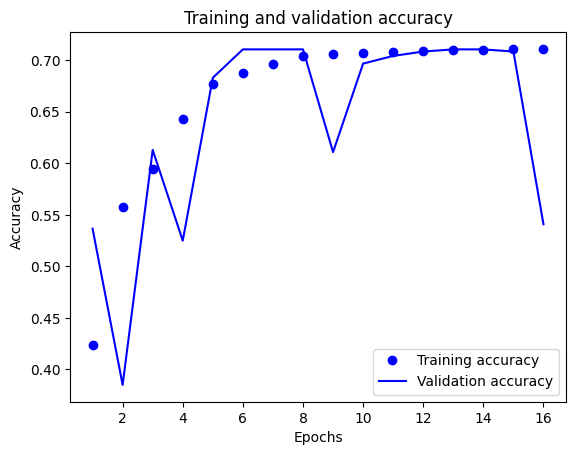

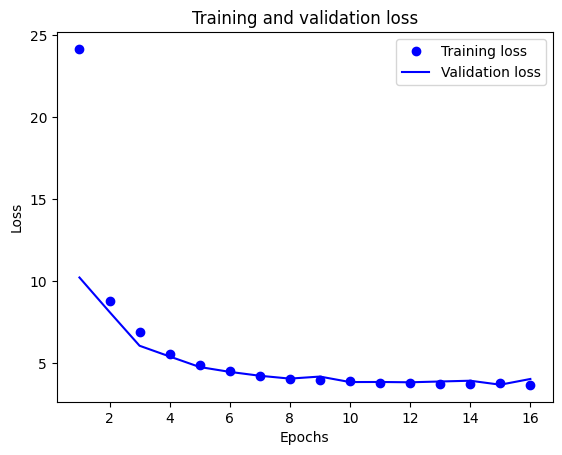

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Matriz de confusión y métricas relevantes



In [36]:
labels_fit = []
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_fit.append(np.asarray(label_batch))

labels_fit_matriz = np.concatenate(labels_fit)
labels_fit_matriz = np.array([np.argmax(i, axis = - 1) for i in labels_fit_matriz]).flatten()

Text(0.5, 1.0, 'Matriz de confusión promedio de los KFold')

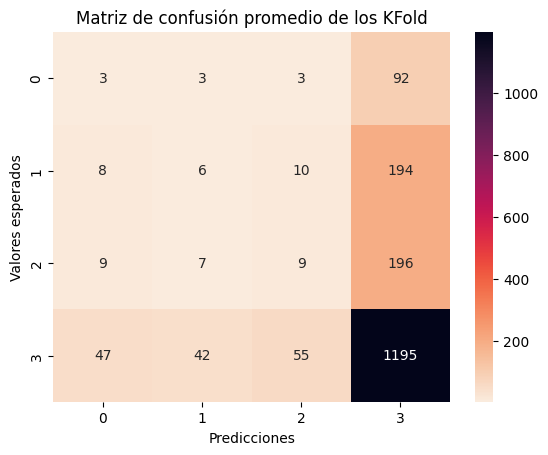

In [38]:
matrices_de_confusión = []
for i in range(len(predicciones)):
  cf = metrics.confusion_matrix(labels_fit_matriz,predicciones[i])
  matrices_de_confusión.append(cf)

matriz_promedio = np.mean(matrices_de_confusión, axis=0, dtype=int)

sns.heatmap(matriz_promedio, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusión promedio de los KFold')

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 1s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[   0    0    0    0    0  184    0]
 [   0    0    0    0    0  289    0]
 [   0    0    0    0    0  616    0]
 [   0    0    0    0    0   65    0]
 [   0    0    0    0    0  624    0]
 [   0    0    0    0    0 3755    0]
 [   0    0    0    0    0   80    0]]


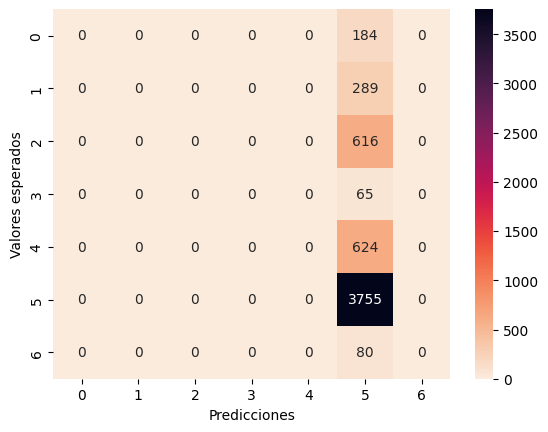

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.00      0.00      0.00       289
           2       0.00      0.00      0.00       616
           3       0.00      0.00      0.00        65
           4       0.00      0.00      0.00       624
           5       0.67      1.00      0.80      3755
           6       0.00      0.00      0.00        80

    accuracy                           0.67      5613
   macro avg       0.10      0.14      0.11      5613
weighted avg       0.45      0.67      0.54      5613



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
#fig, ax = plot_confusion_matrix(conf_mat = cf)
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 30ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[   0    0    0    0    0   78    0]
 [   0    0    0    0    0  123    0]
 [   0    0    0    0    0  242    1]
 [   0    0    0    0    0   27    0]
 [   0    0    0    0    0  267    0]
 [   0    0    0    0    0 1583   26]
 [   0    0    0    0    0   34    0]]


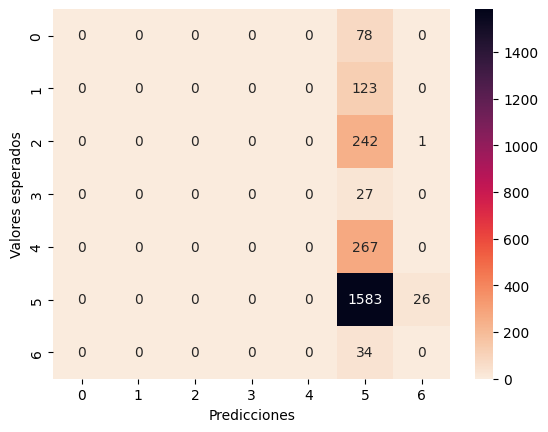

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.00      0.00      0.00       123
           2       0.00      0.00      0.00       243
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00       267
           5       0.67      0.98      0.80      1609
           6       0.00      0.00      0.00        34

    accuracy                           0.66      2381
   macro avg       0.10      0.14      0.11      2381
weighted avg       0.45      0.66      0.54      2381



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
#fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 36ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[   0    0    0    0    0   65    0]
 [   0    0    0    0    0  101    1]
 [   0    0    0    0    0  202    0]
 [   0    0    0    0    0   23    0]
 [   0    0    0    0    0  221    1]
 [   0    0    0    0    0 1316   24]
 [   0    0    0    0    0   28    0]]


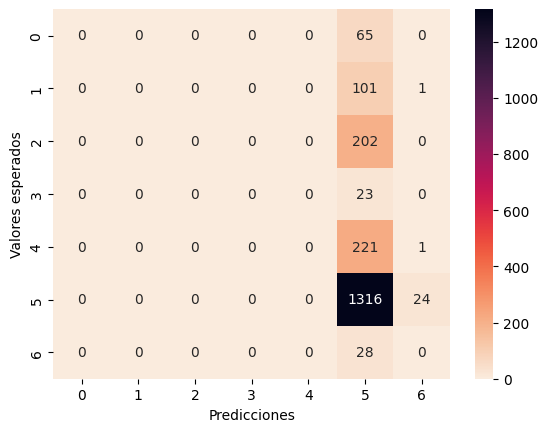

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00       202
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00       222
           5       0.67      0.98      0.80      1340
           6       0.00      0.00      0.00        28

    accuracy                           0.66      1982
   macro avg       0.10      0.14      0.11      1982
weighted avg       0.45      0.66      0.54      1982



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')


## It canbe used in any platform
#fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_InceptionV3.tflite"
tflite_model_file.write_bytes(tflite_model)

NameError: ignored

In [ ]:
model.save('modelo.h5')